# DSCI100 Project: Predicting Usage of a Minecraft Server

## Introduction

The Pacific Laboratory for Artificial Intelligence (PLAI) is currently running a Minecraft server and collecting data on their actions. Such data can be used to determine the quantity and allocation of resources and efforts. In particular, they are interested in understanding what contributes to game-related newsletter subscriptions, as it can aid them in engaging more players. This report seeks to answer the question: Can a user's played hours and age predict subscription to a game-related newsletter in the Minecraft player data? This will be done using a k-nearest neighbors (knn) classification model.

The original player data recieved contains 196 observations and 7 variables:
 
* experience: character vector describing the adeptness of a player
* subscribe: logical vector if the player is subscribed to a related game newsletter
* hashedEmail: character vector corresponding to a unique individual's email
* played_hours: double precision numerical vector of hours a player has spent on the server
* name: character vector of a player's name
* gender: character vector of a player's gender
* Age: double precision numerical vector of a player's age

There are a few issues that arise especially when building a kknn model, such as the presence of NAs. The model will require numerical distances to calculate nearest neighbours; NA rows should be removed, as they cannot contribute to this analysis. Additionally, many of the player hours are equal to zero, which is not representative of the users actively involved in the server. Finally, the variable experience could be made into a factor as it contains a select type of strings, although it will not be used in the model. Relevant issues will be addressed in the wrangling of data.

## Methods & Results

### Tidying Data

To perform the kknn classification model, I firstly address the concerns outlined in the introduction by wrangling the data. I loaded in the tidyverse, repr, tidymodels, and themis packages with the library function. Then, using the filter function, I removed any instances of NAs and zeroes in the Age and played_hours variables respectively. Furthermore, although the subscribe variable is a boolean, I converted it to a factor with mutate as the classification package will not run otherwise. Finally, I selected the relevant variables of subscribe, played_hours, and Age, leaving a tidied dataset for analysis. 109 observations with the 3 variables:

* subscribe: factor variable if the player is subscribed to a related game newsletter
* played_hours: double precision numerical vector of hours a player has spent on the server
* Age: double precision numerical vector of a player's age

With this new tidied data, I performed a summary of its contents. This showed that the played hours ranges from 0.1 to 233.1 hours with a median of 0.5, and the age ranges from 8 to 49 with a median of median of 19. There were more subscribers than non-subscribers, the ratio being 84:25. Fixing this imbalance will be done in the model recipe.

In [14]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 6)

In [15]:
players <- read_csv("data/players.csv", show_col_types = FALSE)

players_tidy <- players |>
    filter(played_hours > 0, Age != "NA") |>
    mutate(subscribe = as.factor(subscribe)) |>
    select(played_hours, Age, subscribe)

players_tidy

summary(players_tidy)

played_hours,Age,subscribe
<dbl>,<dbl>,<fct>
30.3,9,TRUE
3.8,17,TRUE
0.7,21,TRUE
⋮,⋮,⋮
0.1,44,TRUE
0.3,22,FALSE
2.3,17,FALSE


  played_hours         Age        subscribe 
 Min.   :  0.10   Min.   : 8.00   FALSE:25  
 1st Qu.:  0.10   1st Qu.:17.00   TRUE :84  
 Median :  0.50   Median :19.00             
 Mean   : 10.51   Mean   :20.57             
 3rd Qu.:  1.80   3rd Qu.:23.00             
 Max.   :223.10   Max.   :49.00             

### Initial Exploratory Analysis

To perform an exploratory initial analysis, I created a visualization with the tidy data using a scatterplot with ggplot. This would allow me to see if there is any visual indication of the two variables, time played and age, separating subscription differences. The x-axis depicts age, the y-axis depicts played hours, and the colour/shape depicts the subscription state. The y-axis was also log scaled, as there were many outliers that made the unscaled graph difficult to read; scaling the y-axis allows for a more clear visualization of all the played hours recorded. 

From Figure 1 and the summary prior, it appeared that there were more subcribers than non-subscribers, which is addressed in the model. From the visualization, most players fall between 15 to 25 years old. There is no clear linear relationship between player age and hours; at lower played hours, there is mixed overlap between the subscription statuses. However, it seems that for a higher amount of played hours (above 10), a player is likely subscribed. Such observations indicate that played hours might aid in predicting subscription status. Thus, the k-nearest neighbors classification model was developed to test the extent of this prediction.

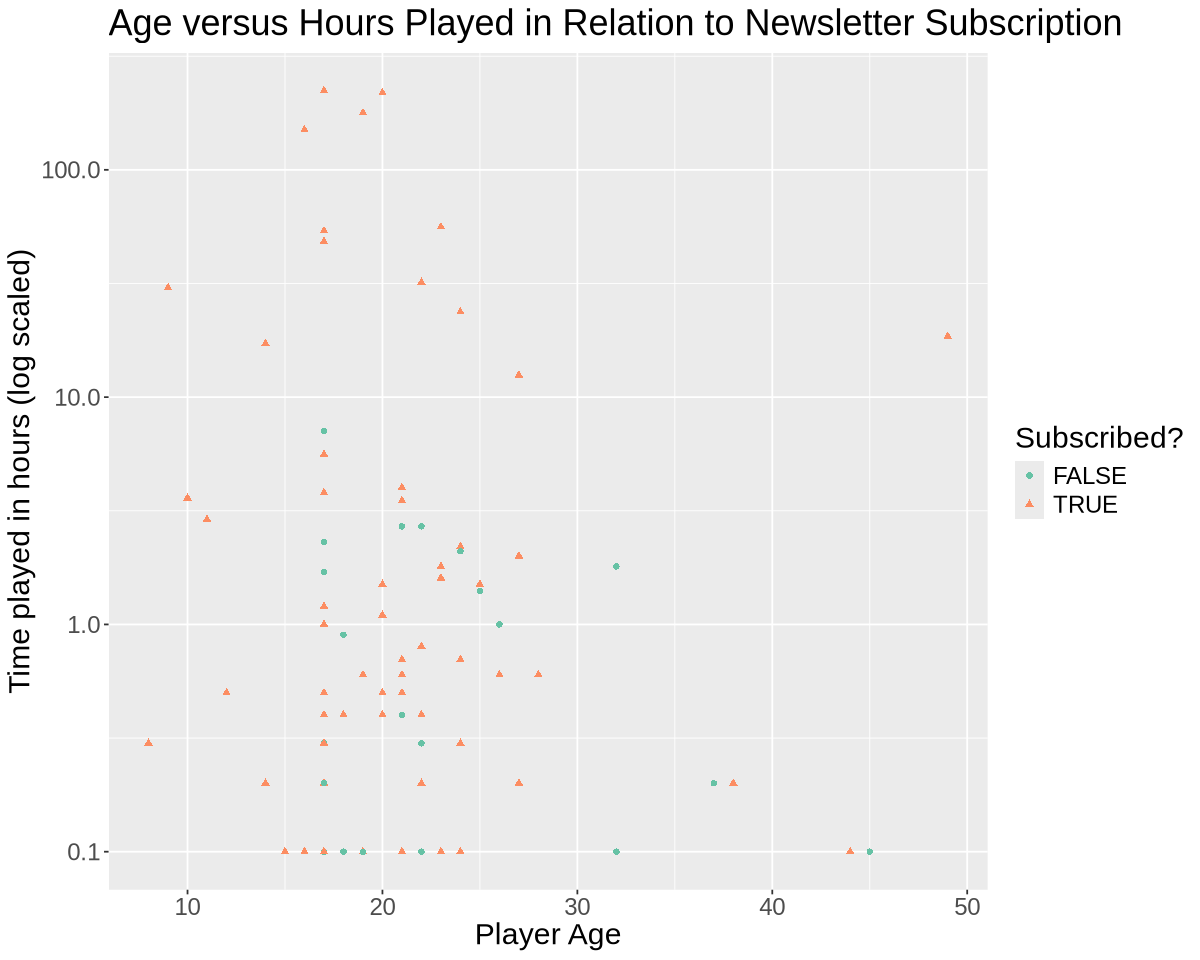

In [16]:
options(repr.plot.height = 8, repr.plot.width = 10)

players_plot <- players_tidy |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe, shape = subscribe)) +
    geom_point() +
    labs(x = "Player Age", y = "Time played in hours (log scaled)", title = "Age versus Hours Played in Relation to Newsletter Subscription",
         color = "Subscribed?", shape = "Subscribed?") +
    theme(text = element_text(size = 18)) +
    scale_color_brewer(palette = "Set2") +
    scale_y_log10()

players_plot

Fig. 1: Scatterplot depicting time played versus age, categorized by if they are subscribed or not.

### Tuning the Classifier

We can now begin the analysis using a classification model. This model is appropriate for this data, given that played_hours and age are both numerical (and therefore can calculate euclidian distances), and that we are classifying players on if they are subscribed or not. However, this model is limited by only accounting for quantitative observations, although there are multiple other qualitative observations recorded in the data. Moreover, this model assumes that any two points that are near each other are similar. Looking at the preliminary analysis, this may not be the case for all points, especially in the bottom half of the graph. Nonetheless, other methods such as linear regression will perform more poorly, as there is no clear linear relationship between the two variables. Clustering would also be unapplicable, as there is already have a subgroup we want to identify (subscribed or not subscribed). As such, I proceeded with using a k-nearest neighbors classification model.

Firstly, I split the data into two sets for future validation: 75% is in training while 25% is in testing. Setting aside this testing data is important to evaluate the trained model on new data, thus reducing the risk of overfitting. Moreover, the stratification variable was set to subscribe for a representative amount of both non-subscribers and subscribers in each set. To tune the classifer, or choose the optimal k-value, the training set will be further split into 5 different sets for cross validation, a method to prevent overfitting and to test models on unseen data. Also, the data is scaled, centered, and balanced in the recipe so that all values and categories contribute equally to calculating distance. Considering the size of the dataset, I tested k values between 1 to 20, and graphed the accuracy versus the k value to find the highest. 

neighbors,mean
<dbl>,<dbl>
11,0.6917647
12,0.6917647


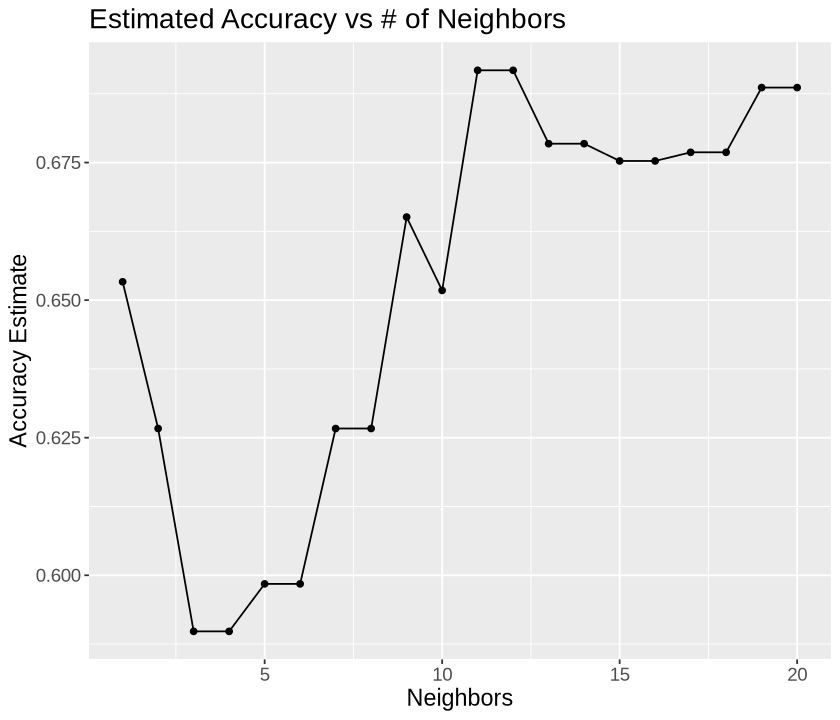

In [17]:
set.seed(100)

# setting up sets, recipe, and specifications
player_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

player_recipe <- recipe(subscribe ~ . , data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

player_vfold <- vfold_cv(player_training, v = 5, strata = subscribe)

# putting it together in a workflow
k_compare <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# plotted visualization
options(repr.plot.height = 6, repr.plot.width = 7)
k_compare_graph <- k_compare |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Estimated Accuracy vs # of Neighbors") +
    theme(text = element_text(size = 14))

# best k value & accuracy
k_choice <- k_compare |>
    slice_max(mean, n = 1) |>
    select(neighbors, mean)

k_compare_graph
k_choice

Fig. 2: Plot of estimated accuracy versus number of neighbours.

After performing 5 fold cross validation to estimate the optimal value of k, a line plot was created to visualize the variation. The result of Figure 2 revealed that the highest estimated accuracy is 69% for both k = 11 and 12. Thus, k = 11 will be used as it will remove the issue of having a tie between categories. With the tuned classifier and k value, the model's performance can be evaluated on the testing set created earlier.

### Evaluating on the Testing Set

In evaluation, the same recipe is used, but a new model must be built with k = 11. The new model was put into a workflow and fitted to the training data, then predicted the testing data. For evaluation, I determined the accuracy and precision, as well as a confusion matrix. This is all done with the positive class as the non-subscribers.

In [23]:
# new model
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

# fitted through workflow
player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_training)

player_predictions <- predict(player_fit, player_testing) |>
    bind_cols(player_testing)

# stats
player_model_accuracy <- player_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_model_precision <- player_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "first")

player_confusion <- player_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

player_model_accuracy
player_model_precision
player_confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5357143


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.2


          Truth
Prediction FALSE TRUE
     FALSE     2    8
     TRUE      5   13

The classification model revealed poor results, with a 54% accuracy and a 20% precision. It appears that the model was especially poor at predicting non-subscribers, as only 2 of 10 "false" predictions were actually false. There were more correct "true" predictions (about 72% of subscriber predictions were correct), although having this imbalance is an issue of overpredicting subscribers. A 54% accuracy is not much better than using a coin flip to determine if a player is subscribed. This result reveals that the model underpredicts the positive class and would not be a good fit for correctly identifying both non-subscribers and subscribers.

## Discussion